In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install prophet

>>> [1단계] 데이터 로드 및 전처리...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 - 파일 로드 성공: 108행

>>> [2단계] 변수 5개 선정 및 정규화...
 - 선정된 변수: ['자동차수리비', '자동차 등록대수 현황', '소비자 심리 지수 CSI', '환율', '국내(RV차량)']

>>> [3단계] 앙상블 모델 학습 (Strong Regularization)...

>>> [4단계] 모델 적합도 확인 및 시각화...
 - 검증 데이터(최근 20%) RMSE: 7,433


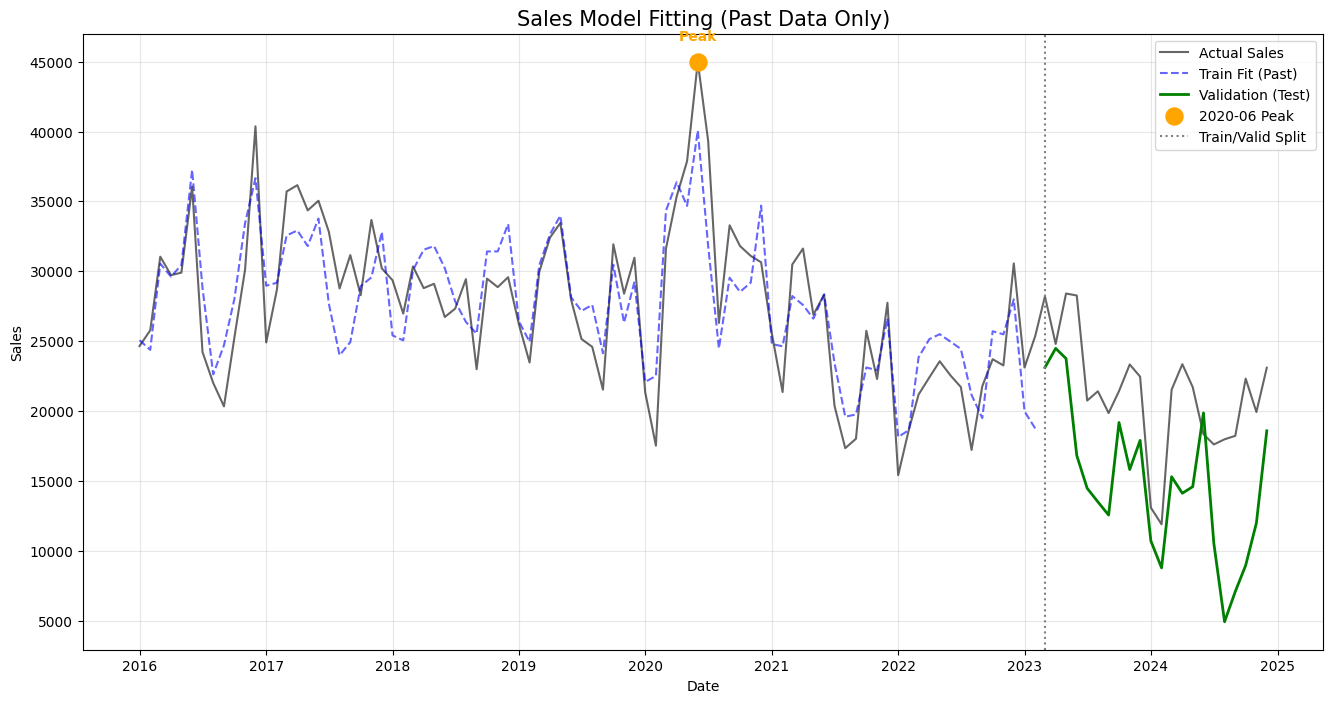

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import xgboost as xgb
from google.colab import drive

# ========================================================
# 1. 데이터 로드 및 날짜 강제 생성 (전처리)
# ========================================================
print(">>> [1단계] 데이터 로드 및 전처리...")

drive.mount('/content/drive')

try:
    file_path = '/content/drive/MyDrive/총변수최종.CSV'
    data = pd.read_csv(file_path, thousands=',')
    print(f" - 파일 로드 성공: {len(data)}행")
except Exception as e:
    print(f"!! 파일 로드 오류: {e}")
    # (테스트용 더미 데이터)
    data = pd.DataFrame({'날짜': range(108), '국내(PC차량)': [20000 + x*10 for x in range(108)]})

# [날짜 처리] 2016-01부터 강제 생성
data['ds'] = pd.date_range(start='2016-01-01', periods=len(data), freq='MS')

# 불필요한 날짜 컬럼 제거
date_cols_to_drop = ['일시', 'Date', 'date', 'Time', 'time', '년월', '시점', '날짜']
data = data.drop(columns=[c for c in date_cols_to_drop if c in data.columns], errors='ignore')

# 타겟 및 변수 분리
target_col = '국내(PC차량)'
X_all = data.drop(['ds', target_col], axis=1)
X_all = X_all.select_dtypes(include=[np.number]).ffill().bfill()
y_all = data[target_col]


# ========================================================
# 2. 중요 변수 Top 5 선정 & 정규화
# ========================================================
print("\n>>> [2단계] 변수 5개 선정 및 정규화...")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_all, y_all)
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
top_5_cols = importances.sort_values(ascending=False).head(5).index.tolist()
print(f" - 선정된 변수: {top_5_cols}")

scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[top_5_cols] = scaler.fit_transform(data[top_5_cols])


# ========================================================
# 3. 모델 학습 (과적합 방지 강화)
# ========================================================
print("\n>>> [3단계] 앙상블 모델 학습 (Strong Regularization)...")

# 데이터셋 준비
df_prophet = pd.DataFrame()
df_prophet['ds'] = data['ds']
df_prophet['y'] = y_all.values
for col in top_5_cols:
    df_prophet[col] = data_scaled[col].values

# 학습/검증 분리 (8:2)
split_idx = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_idx]
valid_df = df_prophet.iloc[split_idx:]

# (A) Prophet 학습 (추세 둔감화 강화)
model_prophet = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
    changepoint_prior_scale=0.005 # [중요] 0.01 -> 0.005로 더 낮춤 (추세 민감도 감소)
)
for col in top_5_cols:
    model_prophet.add_regressor(col)
model_prophet.fit(train_df)

# (B) XGBoost 학습 (모델 단순화 강화)
forecast_train = model_prophet.predict(train_df)
y_train_resid = train_df['y'].values - forecast_train['yhat'].values
X_train_xgb = df_prophet[top_5_cols].iloc[:split_idx]

model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=30,       # [수정] 트리 개수 50 -> 30 (학습 조기 중단)
    learning_rate=0.05,
    max_depth=1,           # [수정] 깊이 2 -> 1 (매우 단순한 트리 사용)
    subsample=0.6,         # 데이터 60%만 사용
    colsample_bytree=0.7,  # 변수 70%만 사용
    reg_alpha=0.5,         # L1 규제 강화
    random_state=42, n_jobs=-1
)
model_xgb.fit(X_train_xgb, y_train_resid)


# ========================================================
# 4. 검증 및 전체 결과 확인
# ========================================================
print("\n>>> [4단계] 모델 적합도 확인 및 시각화...")

# 전체 기간에 대한 예측값 생성
forecast_all = model_prophet.predict(df_prophet)
pred_prophet_all = forecast_all['yhat'].values
pred_resid_all = model_xgb.predict(df_prophet[top_5_cols])
final_pred_all = pred_prophet_all + pred_resid_all

# RMSE 평가 (검증 데이터 기준)
valid_pred = final_pred_all[split_idx:]
valid_true = valid_df['y'].values
rmse = np.sqrt(mean_squared_error(valid_true, valid_pred))
print(f" - 검증 데이터(최근 20%) RMSE: {rmse:,.0f}")

# 시각화
plt.figure(figsize=(16, 8))

# 1) 실제값 (검은색)
plt.plot(df_prophet['ds'], y_all, label='Actual Sales', color='black', linewidth=1.5, alpha=0.6)

# 2) 학습 구간 예측 (파란색 점선)
train_dates = df_prophet['ds'][:split_idx]
train_preds = final_pred_all[:split_idx]
plt.plot(train_dates, train_preds, label='Train Fit (Past)', color='blue', linestyle='--', alpha=0.6)

# 3) 검증 구간 예측 (초록색 실선 - 여기가 진짜 실력)
valid_dates = df_prophet['ds'][split_idx:]
valid_preds = final_pred_all[split_idx:]
plt.plot(valid_dates, valid_preds, label='Validation (Test)', color='green', linewidth=2)

# [검증] 2020년 6월 피크 지점 표시
peak_date_check = pd.to_datetime('2020-06-01')
if peak_date_check in df_prophet['ds'].values:
    real_val = df_prophet.loc[df_prophet['ds'] == peak_date_check, 'y'].values[0]
    plt.scatter(peak_date_check, real_val, color='orange', s=150, zorder=5, label='2020-06 Peak')
    plt.text(peak_date_check, real_val+1500, 'Peak', color='orange', fontweight='bold', ha='center')

# 학습/검증 구분선
plt.axvline(x=valid_dates.iloc[0], color='gray', linestyle=':', label='Train/Valid Split')

plt.title('Sales Model Fitting (Past Data Only)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

>>> 2025년 변수 데이터 로드 및 예측 시작...
 - 파일 로드 성공: 12행

>>> [2025년 최종 예측 결과]
         Date  Final_Forecast
0  2025-01-01      456.708056
1  2025-02-01    -1610.157133
2  2025-03-01     3265.289862
3  2025-04-01     2544.226980
4  2025-05-01     -375.493076
5  2025-06-01    -1565.657041
6  2025-07-01    -6455.008498
7  2025-08-01    -9797.400371
8  2025-09-01   -10742.263390
9  2025-10-01    -5996.616514
10 2025-11-01    -6548.396633
11 2025-12-01    -4690.268787


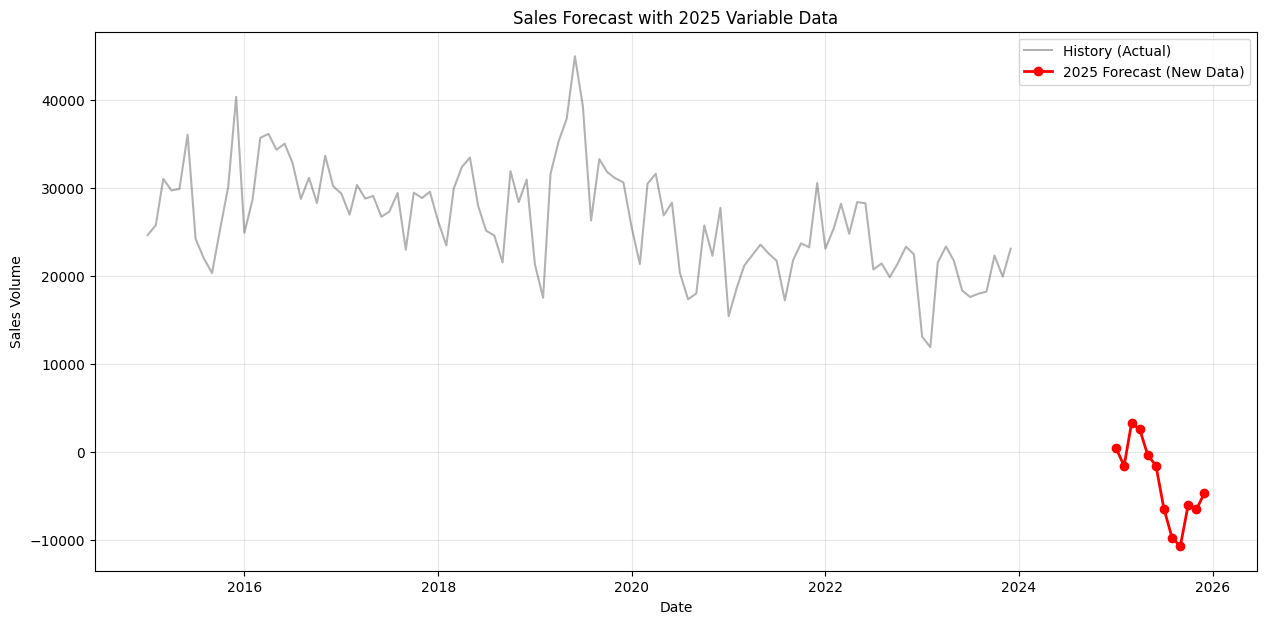

In [ ]:
# =========================================================
#   [실전 예측] 2025년 변수 파일('/content/drive/MyDrive/2025변수.CSV') 활용
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt

print(">>> 2025년 변수 데이터 로드 및 예측 시작...")

# 1. 2025년 변수 데이터 불러오기
try:
    # 사용자님이 지정하신 파일 경로
    file_path_2025 = '/content/drive/MyDrive/2025변수.CSV'
    df_2025 = pd.read_csv(file_path_2025, thousands=',') # 숫자 쉼표 제거 옵션 포함
    print(f" - 파일 로드 성공: {len(df_2025)}행")
except Exception as e:
    print(f"!! 파일 로드 오류: {e}")
    # (파일이 없을 경우를 대비한 비상용 코드 - 실제 실행 시에는 무시됨)
    print("   (테스트용 데이터를 생성합니다)")
    df_2025 = pd.DataFrame([last_row_scaled.values[0]] * 12, columns=top_5_cols) # 변수명은 학습 모델 기준

# 2. 날짜 생성 (2025년 1월 ~ 12월)
# 데이터가 12개 행이라고 가정하고 날짜를 부여합니다.
df_2025['ds'] = pd.date_range(start='2025-01-01', periods=len(df_2025), freq='MS')

# 3. 데이터 정규화 (Normalization)
# [중요] 학습할 때 사용했던 'scaler' 객체를 그대로 사용해야 기준이 맞습니다.
# 파일에 있는 변수 중 모델 학습에 사용된 'top_5_cols'만 뽑아서 변환합니다.
df_2025_scaled = df_2025.copy()
df_2025_scaled[top_5_cols] = scaler.transform(df_2025[top_5_cols])


# --- [Step 1] Prophet 예측 (추세) ---
future_prophet = pd.DataFrame()
future_prophet['ds'] = df_2025['ds']

# 정규화된 2025년 변수 입력
for col in top_5_cols:
    future_prophet[col] = df_2025_scaled[col].values

# Prophet 예측 실행
pred_prophet_2025 = model_prophet.predict(future_prophet)['yhat'].values


# --- [Step 2] XGBoost 예측 (잔차 보정) ---
# XGBoost 입력용 데이터 (정규화된 5개 변수)
X_2025_xgb = df_2025_scaled[top_5_cols]

# 오차 예측 실행
pred_resid_2025 = model_xgb.predict(X_2025_xgb)


# --- [Step 3] 최종 앙상블 결과 ---
final_pred_2025 = pred_prophet_2025 + pred_resid_2025


# 4. 결과 정리 및 출력
result_2025 = pd.DataFrame({
    'Date': df_2025['ds'],
    'Final_Forecast': final_pred_2025
})

print("\n>>> [2025년 최종 예측 결과]")
print(result_2025)

# (선택) CSV 저장
# result_2025.to_csv('2025_forecast_result.csv', index=False)


# 5. 그래프로 확인 (전체 기간 연결)
# 기존 과거 데이터(df_prophet)와 합쳐서 그립니다.
plt.figure(figsize=(15, 7))

# 과거 실제값
plt.plot(df_prophet['ds'], y_all, label='History (Actual)', color='black', alpha=0.3)

# 2025년 예측값
plt.plot(result_2025['Date'], result_2025['Final_Forecast'],
         label='2025 Forecast (New Data)', color='red', marker='o', linewidth=2)

plt.title('Sales Forecast with 2025 Variable Data')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

>>> [1단계] 데이터 로드 및 기간 설정 (2016.01 ~ 2024.12)...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  - 확인: 데이터 행 수와 지정된 기간(108개월)이 정확히 일치합니다.

>>> [2단계] 변수 중요도 분석 및 Top 10 선정...
최종 선정된 10개 변수: ['자동차수리비', '자동차 등록대수 현황', '소비자 심리 지수 CSI', '환율', '국내(RV차량)']

>>> [3단계] 변수 정규화 (MinMaxScaler)...

>>> [4단계] Prophet 모델 학습 (2016~2024)...
  - 훈련 데이터 기간: 2016-01-01 ~ 2023-02-01
  - 검증 데이터 기간: 2023-03-01 ~ 2024-12-01

>>> [5단계] XGBoost 모델 학습 (잔차 보정)...

>>> [6단계] 최종 앙상블 예측 및 평가...

[모델 성능 비교 (RMSE) - 2016~2024]
1. Prophet 단독: 8,363
2. 앙상블 모델 : 8,362
--> 개선폭: 2


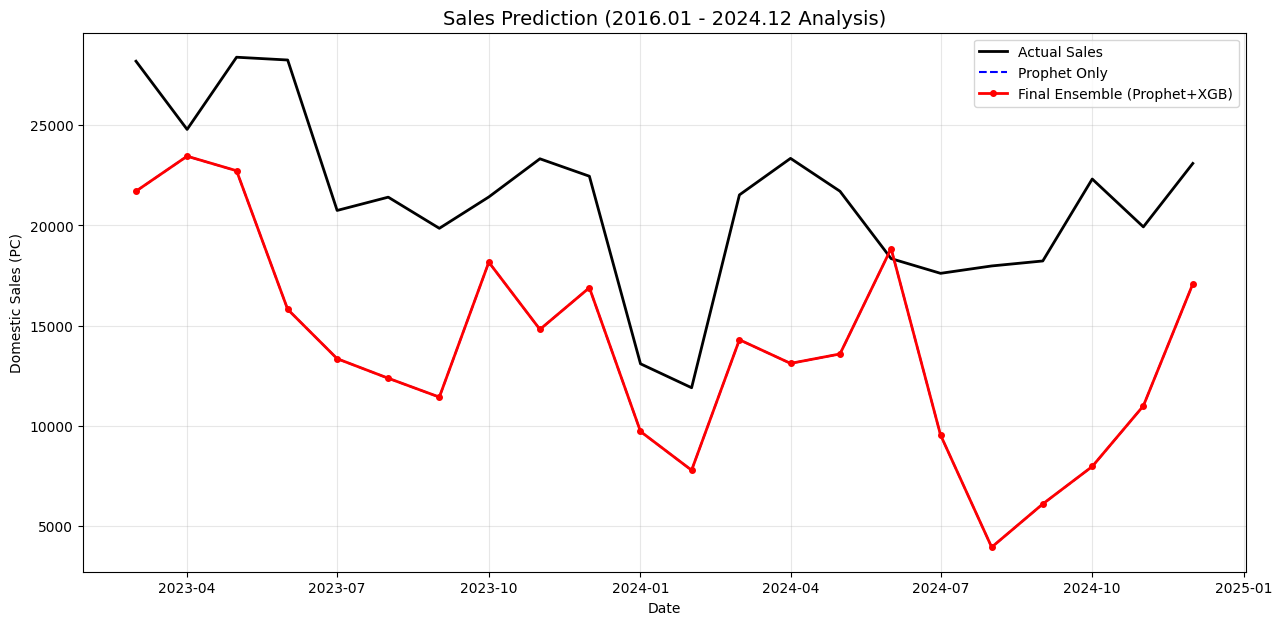

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import xgboost as xgb
from google.colab import drive

# ==========================================
# 1. 데이터 로드 및 날짜 범위 설정 (2016 ~ 2024)
# ==========================================
print(">>> [1단계] 데이터 로드 및 기간 설정 (2016.01 ~ 2024.12)...")

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 파일 읽기
try:
    file_path = '/content/drive/MyDrive/총변수최종.CSV'
    data = pd.read_csv(file_path, thousands=',')
except Exception as e:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요. ({e})")
    raise

# 결측치 처리
data = data.ffill().bfill()

# [핵심 수정] 2016년 1월부터 2024년 12월까지 날짜 생성 (총 108개월)
target_dates = pd.date_range(start='2016-01-01', end='2024-12-01', freq='MS')
required_len = len(target_dates)

# 데이터 길이와 날짜 길이 매칭 (데이터 무결성 확보)
current_len = len(data)

if current_len > required_len:
    print(f"  - 알림: 데이터({current_len}행)가 지정된 기간({required_len}행)보다 많습니다.")
    print("  - 최근 데이터를 기준으로 2016~2024년에 맞게 자릅니다.")
    data = data.iloc[-required_len:].reset_index(drop=True)
elif current_len < required_len:
    print(f"  - 경고: 데이터({current_len}행)가 지정된 기간({required_len}행)보다 부족합니다.")
    print("  - 데이터 길이에 맞춰 날짜 범위를 조정합니다.")
    target_dates = target_dates[:current_len]
else:
    print(f"  - 확인: 데이터 행 수와 지정된 기간({required_len}개월)이 정확히 일치합니다.")

# X(변수), y(타겟) 분리
X_all = data.drop('국내(PC차량)', axis=1)
y_all = data['국내(PC차량)']


# ==========================================
# 2. 과적합 방지를 위한 핵심 변수 10개 선정
# ==========================================
print("\n>>> [2단계] 변수 중요도 분석 및 Top 10 선정...")

# RandomForest로 중요도 파악
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_all, y_all)

# 중요도 순으로 정렬하여 상위 5개만 추출
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
top_5_cols = importances.sort_values(ascending=False).head(5).index.tolist()

print(f"최종 선정된 10개 변수: {top_5_cols}")


# ==========================================
# 3. 데이터 정규화 (Normalization)
# ==========================================
print("\n>>> [3단계] 변수 정규화 (MinMaxScaler)...")

scaler = MinMaxScaler()
data_scaled = data.copy()
# 선정된 10개 변수만 정규화 진행
data_scaled[top_5_cols] = scaler.fit_transform(data[top_5_cols])


# ==========================================
# 4. Prophet 모델 학습 (추세 예측)
# ==========================================
print("\n>>> [4단계] Prophet 모델 학습 (2016~2024)...")

# Prophet용 데이터프레임 생성
df_prophet = pd.DataFrame()
df_prophet['ds'] = target_dates
df_prophet['y'] = y_all.values
# 5개 변수 추가
for col in top_5_cols:
    df_prophet[col] = data_scaled[col].values

# 훈련/검증 데이터 분리
# 2016~2023년(훈련), 2024년(검증)으로 나누거나 비율로 나눔
# 여기서는 8:2 비율 유지 (약 2023년 초반까지 훈련)
split_idx = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_idx]
valid_df = df_prophet.iloc[split_idx:]

print(f"  - 훈련 데이터 기간: {train_df['ds'].dt.date.iloc[0]} ~ {train_df['ds'].dt.date.iloc[-1]}")
print(f"  - 검증 데이터 기간: {valid_df['ds'].dt.date.iloc[0]} ~ {valid_df['ds'].dt.date.iloc[-1]}")

# Prophet 모델 정의
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.01  # 과적합 방지
)

# Regressor 등록
for col in top_5_cols:
    model_prophet.add_regressor(col)

# 학습
model_prophet.fit(train_df)

# 예측
forecast_train = model_prophet.predict(train_df)
forecast_valid = model_prophet.predict(valid_df)


# ==========================================
# 5. XGBoost 모델 학습 (잔차 보정)
# ==========================================
print("\n>>> [5단계] XGBoost 모델 학습 (잔차 보정)...")

# 잔차(실제값 - Prophet예측값) 계산
y_train_resid = train_df['y'].values - forecast_train['yhat'].values

# XGBoost 입력 데이터
X_train_xgb = train_df[top_5_cols]
X_valid_xgb = valid_df[top_5_cols]

# XGBoost 모델 정의
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=25,
    learning_rate=1e-4,
    max_depth=2,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# 잔차 학습
model_xgb.fit(X_train_xgb, y_train_resid)


# ==========================================
# 6. 최종 예측 및 시각화
# ==========================================
print("\n>>> [6단계] 최종 앙상블 예측 및 평가...")

# 1) XGBoost로 검증 구간 잔차 예측
pred_resid_valid = model_xgb.predict(X_valid_xgb)

# 2) 최종 예측 = Prophet예측 + XGBoost보정
final_pred_valid = forecast_valid['yhat'].values + pred_resid_valid

# 3) 성능 평가 (RMSE)
y_true = valid_df['y'].values
rmse_prophet = np.sqrt(mean_squared_error(y_true, forecast_valid['yhat'].values))
rmse_ensemble = np.sqrt(mean_squared_error(y_true, final_pred_valid))

print(f"\n[모델 성능 비교 (RMSE) - 2016~2024]")
print(f"1. Prophet 단독: {rmse_prophet:,.0f}")
print(f"2. 앙상블 모델 : {rmse_ensemble:,.0f}")
print(f"--> 개선폭: {rmse_prophet - rmse_ensemble:,.0f}")

# 4) 시각화
plt.figure(figsize=(15, 7))
plt.plot(valid_df['ds'], y_true, label='Actual Sales', color='black', linewidth=2)
plt.plot(valid_df['ds'], forecast_valid['yhat'], label='Prophet Only', linestyle='--', color='blue')
plt.plot(valid_df['ds'], final_pred_valid, label='Final Ensemble (Prophet+XGB)', color='red', linewidth=2, marker='o', markersize=4)

plt.title('Sales Prediction (2016.01 - 2024.12 Analysis)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Domestic Sales (PC)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

>>> [7단계] 2025년 데이터 로드 및 예측 수행...
  - 2025년 데이터 로드 성공

>>> [8단계] 2025년 월별 예측 결과
   YearMonth  Prophet_Pred  Residual_Correction  Final_Prediction
0    2025-01         7,079                    3             7,082
1    2025-02         5,974                    2             5,976
2    2025-03        10,503                    2            10,505
3    2025-04         9,198                    2             9,200
4    2025-05         6,924                    2             6,925
5    2025-06         6,580                    3             6,583
6    2025-07           133                    3               136
7    2025-08        -5,193                    3            -5,189
8    2025-09        -4,700                    3            -4,697
9    2025-10         1,600                    2             1,601
10   2025-11         1,804                    2             1,806
11   2025-12         4,025                    2             4,026

  - 결과 파일 저장 완료: /content/drive/MyDrive/2025_예측결과.csv


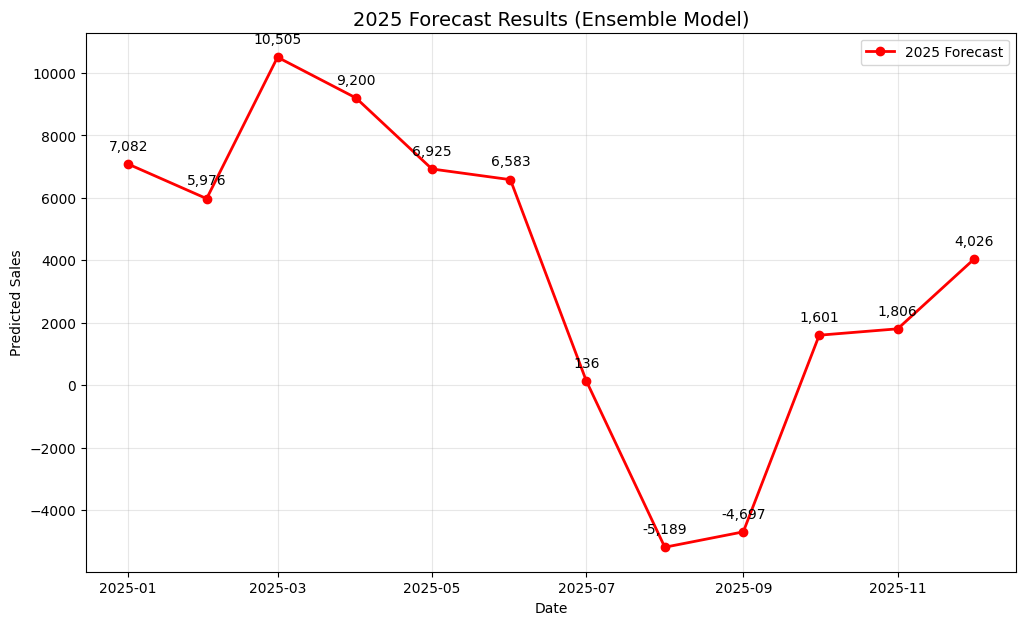

In [ ]:
# ==========================================
# 7. 2025년 미래 데이터 예측 (Inference)
# ==========================================
print(">>> [7단계] 2025년 데이터 로드 및 예측 수행...")

# 1) 2025년 변수 데이터 로드
try:
    file_path_2025 = '/content/drive/MyDrive/2025변수.CSV'
    data_2025 = pd.read_csv(file_path_2025, thousands=',')
    print("  - 2025년 데이터 로드 성공")
except Exception as e:
    print(f"오류: 2025년 파일을 찾을 수 없습니다. ({e})")
    raise

# 2) 날짜 생성 (2025-01 ~ 2025-12)
# 데이터 행 수에 맞춰 날짜 생성 (일반적으로 12개월)
dates_2025 = pd.date_range(start='2025-01-01', periods=len(data_2025), freq='MS')

# 3) 변수 매칭 및 전처리 (중요!)
# 학습 때 선정된 Top 5 변수가 2025년 파일에도 있는지 확인
missing_cols = [col for col in top_5_cols if col not in data_2025.columns]
if missing_cols:
    raise ValueError(f"오류: 학습에 사용된 변수가 2025년 파일에 없습니다. 누락된 변수: {missing_cols}")

# 결측치 처리 (필요 시)
data_2025 = data_2025.ffill().bfill()

# 스케일링 (학습 데이터의 분포를 그대로 적용하기 위해 transform만 사용)
# 주의: 여기서 fit_transform을 쓰면 2025년 데이터만의 기준으로 왜곡됨
data_2025_scaled = data_2025.copy()
data_2025_scaled[top_5_cols] = scaler.transform(data_2025[top_5_cols])

# 4) Prophet 예측 (기본 추세)
df_prophet_2025 = pd.DataFrame()
df_prophet_2025['ds'] = dates_2025
# 5개 변수 추가
for col in top_5_cols:
    df_prophet_2025[col] = data_2025_scaled[col].values

forecast_2025 = model_prophet.predict(df_prophet_2025)

# 5) XGBoost 예측 (잔차 보정)
X_xgb_2025 = df_prophet_2025[top_5_cols]  # 위에서 이미 스케일링된 값 사용
pred_resid_2025 = model_xgb.predict(X_xgb_2025)

# 6) 최종 앙상블 (Prophet + XGBoost)
final_pred_2025 = forecast_2025['yhat'].values + pred_resid_2025

# ==========================================
# 8. 결과 출력 및 저장
# ==========================================
print("\n>>> [8단계] 2025년 월별 예측 결과")

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    'YearMonth': dates_2025.strftime('%Y-%m'),
    'Prophet_Pred': forecast_2025['yhat'].values,
    'Residual_Correction': pred_resid_2025,
    'Final_Prediction': final_pred_2025
})

# 소수점 정수형 변환 및 출력
pd.options.display.float_format = '{:,.0f}'.format
print(result_df)

# CSV 저장
save_path = '/content/drive/MyDrive/2025_예측결과.csv'
result_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n  - 결과 파일 저장 완료: {save_path}")

# 시각화
plt.figure(figsize=(12, 7))
plt.plot(dates_2025, final_pred_2025, marker='o', color='red', linewidth=2, label='2025 Forecast')
for i, txt in enumerate(final_pred_2025):
    plt.annotate(f"{txt:,.0f}", (dates_2025[i], final_pred_2025[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('2025 Forecast Results (Ensemble Model)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

>>> [1단계] 데이터 로드 및 전처리...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

>>> [2단계] 변수 중요도 분석 및 Top 5 선정...
최종 선정된 5개 변수: ['자동차수리비', '자동차 등록대수 현황', '소비자 심리 지수 CSI', '환율', '국내(RV차량)']

>>> [3단계] 변수 정규화 (MinMaxScaler)...

>>> [4단계] Prophet 모델 학습 (보수적 설정)...

>>> [5단계] XGBoost 모델 학습 (규제 적용)...

>>> [6단계] 최종 앙상블 예측 및 평가...

[모델 성능 비교 (RMSE)]
1. Prophet 단독: 8,223
2. 앙상블 모델 : 6,485
--> 개선폭: 1,737


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


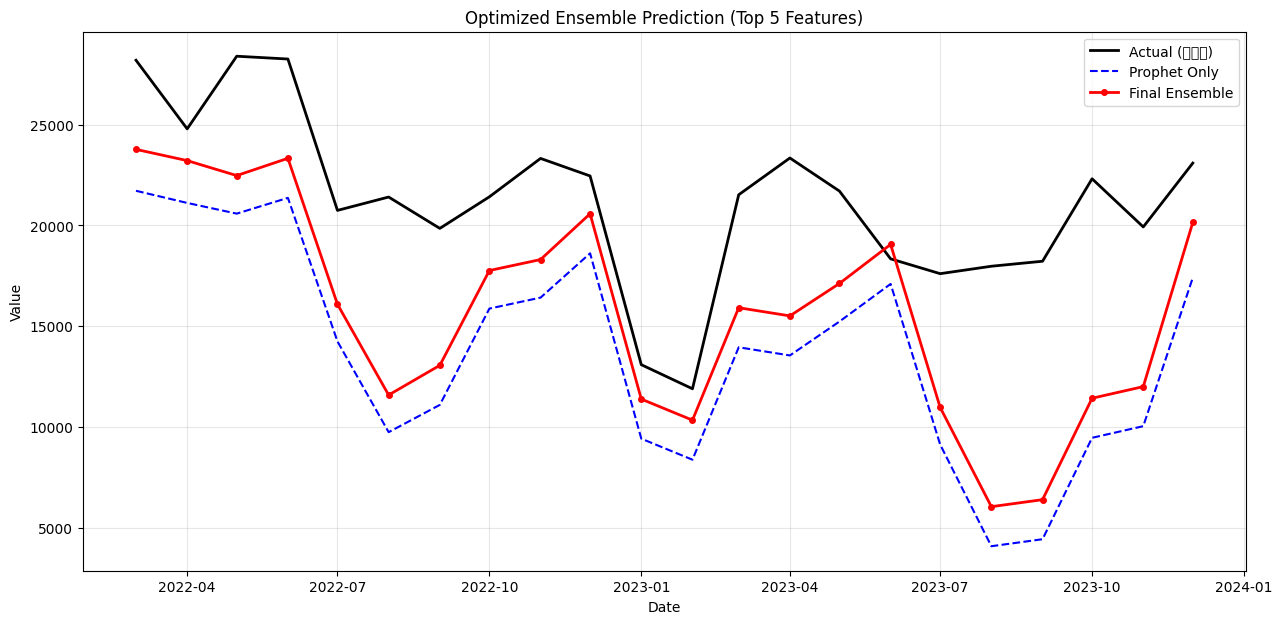

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import xgboost as xgb
from google.colab import drive

# ==========================================
# 1. 데이터 로드 및 기본 전처리
# ==========================================
print(">>> [1단계] 데이터 로드 및 전처리...")

# 구글 드라이브 마운트 (이미 되어 있다면 생략됨)
drive.mount('/content/drive')

# 파일 읽기
try:
    file_path = '/content/drive/MyDrive/총변수최종.CSV'
    data = pd.read_csv(file_path, thousands=',')
except Exception as e:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요. ({e})")
    raise

# 결측치 처리
data = data.ffill().bfill()

# 날짜 인덱스 생성 (2015-01-01 시작 가정)
# 만약 데이터 시작일이 다르다면 'start' 파라미터를 수정하세요.
dates = pd.date_range(start='2015-01-01', periods=len(data), freq='MS')

# X(변수), y(타겟) 분리
X_all = data.drop('국내(PC차량)', axis=1)
y_all = data['국내(PC차량)']


# ==========================================
# 2. 과적합 방지를 위한 핵심 변수 5개 선정
# ==========================================
print("\n>>> [2단계] 변수 중요도 분석 및 Top 5 선정...")

# RandomForest로 중요도 파악
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_all, y_all)

# 중요도 순으로 정렬하여 상위 5개만 추출
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
top_5_cols = importances.sort_values(ascending=False).head(5).index.tolist()

print(f"최종 선정된 5개 변수: {top_5_cols}")


# ==========================================
# 3. 데이터 정규화 (Normalization)
# ==========================================
print("\n>>> [3단계] 변수 정규화 (MinMaxScaler)...")

scaler = MinMaxScaler()
data_scaled = data.copy()
# 선정된 5개 변수만 정규화 진행
data_scaled[top_5_cols] = scaler.fit_transform(data[top_5_cols])


# ==========================================
# 4. Prophet 모델 학습 (추세 예측)
# ==========================================
print("\n>>> [4단계] Prophet 모델 학습 (보수적 설정)...")

# Prophet용 데이터프레임 생성
df_prophet = pd.DataFrame()
df_prophet['ds'] = dates
df_prophet['y'] = y_all.values
# 5개 변수 추가
for col in top_5_cols:
    df_prophet[col] = data_scaled[col].values

# 훈련/검증 데이터 분리 (마지막 12개월을 검증용으로 사용 추천, 여기선 8:2 비율 적용)
split_idx = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_idx]
valid_df = df_prophet.iloc[split_idx:]

# Prophet 모델 정의
# changepoint_prior_scale=0.01 : 추세를 유연하게 바꾸지 않고 둔감하게 만들어 과적합 방지
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.01
)

# Regressor 등록
for col in top_5_cols:
    model_prophet.add_regressor(col)

# 학습
model_prophet.fit(train_df)

# 예측 (훈련 구간 & 검증 구간)
forecast_train = model_prophet.predict(train_df)
forecast_valid = model_prophet.predict(valid_df)


# ==========================================
# 5. XGBoost 모델 학습 (잔차 보정 - 경량화)
# ==========================================
print("\n>>> [5단계] XGBoost 모델 학습 (규제 적용)...")

# 잔차(실제값 - Prophet예측값) 계산
y_train_resid = train_df['y'].values - forecast_train['yhat'].values

# XGBoost 입력 데이터 (선정된 5개 변수)
X_train_xgb = train_df[top_5_cols]
X_valid_xgb = valid_df[top_5_cols]

# XGBoost 모델 정의 (과적합 방지 옵션 적용)
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,       # 트리를 50개만 생성 (조기 종료 효과)
    learning_rate=0.05,    # 학습 속도를 늦춤
    max_depth=2,           # 트리를 얕게 만들어 복잡한 패턴 암기 방지
    subsample=0.7,         # 데이터의 70%만 무작위 사용
    colsample_bytree=0.8,  # 변수의 80%만 무작위 사용
    reg_alpha=0.1,         # L1 규제 (불필요한 가중치 0으로)
    reg_lambda=1.0,        # L2 규제
    random_state=42,
    n_jobs=-1
)

# 잔차 학습
model_xgb.fit(X_train_xgb, y_train_resid)


# ==========================================
# 6. 최종 예측 및 시각화
# ==========================================
print("\n>>> [6단계] 최종 앙상블 예측 및 평가...")

# 1) XGBoost로 검증 구간 잔차 예측
pred_resid_valid = model_xgb.predict(X_valid_xgb)

# 2) 최종 예측 = Prophet예측 + XGBoost보정
final_pred_valid = forecast_valid['yhat'].values + pred_resid_valid

# 3) 성능 평가 (RMSE)
y_true = valid_df['y'].values
rmse_prophet = np.sqrt(mean_squared_error(y_true, forecast_valid['yhat'].values))
rmse_ensemble = np.sqrt(mean_squared_error(y_true, final_pred_valid))

print(f"\n[모델 성능 비교 (RMSE)]")
print(f"1. Prophet 단독: {rmse_prophet:,.0f}")
print(f"2. 앙상블 모델 : {rmse_ensemble:,.0f}")
print(f"--> 개선폭: {rmse_prophet - rmse_ensemble:,.0f}")

# 4) 시각화
plt.figure(figsize=(15, 7))
plt.plot(valid_df['ds'], y_true, label='Actual (실제값)', color='black', linewidth=2)
plt.plot(valid_df['ds'], forecast_valid['yhat'], label='Prophet Only', linestyle='--', color='blue')
plt.plot(valid_df['ds'], final_pred_valid, label='Final Ensemble', color='red', linewidth=2, marker='o', markersize=4)

plt.title(f'Optimized Ensemble Prediction (Top {len(top_5_cols)} Features)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

>>> [7단계] 2025년 데이터 로드 및 예측 수행...
  - 2025년 데이터 로드 성공

>>> [8단계] 2025년 월별 예측 결과
   YearMonth  Prophet_Pred  Residual_Correction  Final_Prediction
0    2025-01         7,061                1,266             8,328
1    2025-02         5,956                1,027             6,984
2    2025-03        10,484                1,027            11,511
3    2025-04         9,173                1,027            10,200
4    2025-05         6,896                1,027             7,923
5    2025-06         6,551                1,493             8,044
6    2025-07           102                1,639             1,741
7    2025-08        -5,229                2,420            -2,809
8    2025-09        -4,736                1,639            -3,096
9    2025-10         1,568                1,027             2,595
10   2025-11         1,773                1,027             2,800
11   2025-12         3,994                1,027             5,021

  - 결과 파일 저장 완료: /content/drive/MyDrive/2025_예측결과.csv


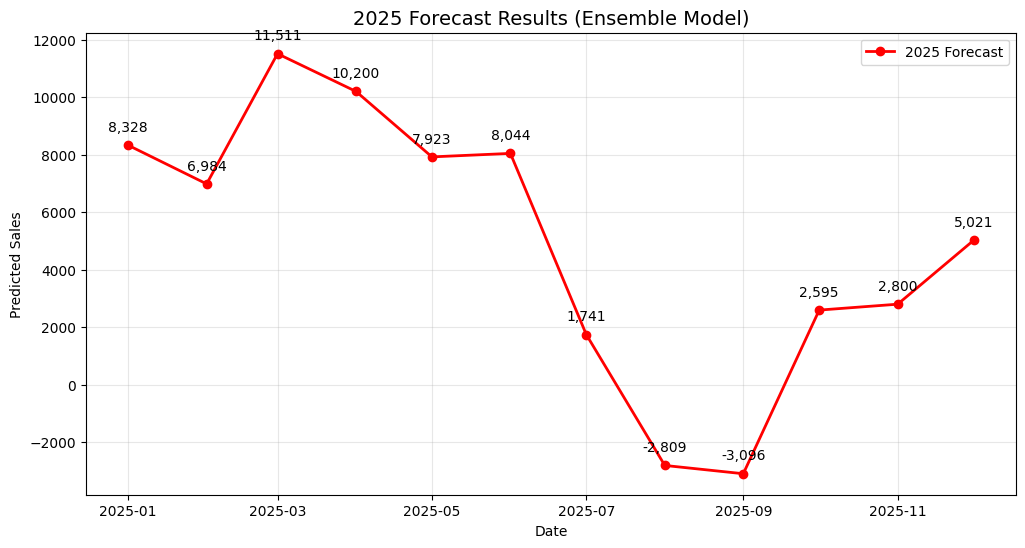

In [ ]:
# ==========================================
# 7. 2025년 미래 데이터 예측 (Inference)
# ==========================================
print(">>> [7단계] 2025년 데이터 로드 및 예측 수행...")

# 1) 2025년 변수 데이터 로드
try:
    file_path_2025 = '/content/drive/MyDrive/2025변수.CSV'
    data_2025 = pd.read_csv(file_path_2025, thousands=',')
    print("  - 2025년 데이터 로드 성공")
except Exception as e:
    print(f"오류: 2025년 파일을 찾을 수 없습니다. ({e})")
    raise

# 2) 날짜 생성 (2025-01 ~ 2025-12)
# 데이터 행 수에 맞춰 날짜 생성 (일반적으로 12개월)
dates_2025 = pd.date_range(start='2025-01-01', periods=len(data_2025), freq='MS')

# 3) 변수 매칭 및 전처리 (중요!)
# 학습 때 선정된 Top 5 변수가 2025년 파일에도 있는지 확인
missing_cols = [col for col in top_5_cols if col not in data_2025.columns]
if missing_cols:
    raise ValueError(f"오류: 학습에 사용된 변수가 2025년 파일에 없습니다. 누락된 변수: {missing_cols}")

# 결측치 처리 (필요 시)
data_2025 = data_2025.ffill().bfill()

# 스케일링 (학습 데이터의 분포를 그대로 적용하기 위해 transform만 사용)
# 주의: 여기서 fit_transform을 쓰면 2025년 데이터만의 기준으로 왜곡됨
data_2025_scaled = data_2025.copy()
data_2025_scaled[top_5_cols] = scaler.transform(data_2025[top_5_cols])

# 4) Prophet 예측 (기본 추세)
df_prophet_2025 = pd.DataFrame()
df_prophet_2025['ds'] = dates_2025
# 5개 변수 추가
for col in top_5_cols:
    df_prophet_2025[col] = data_2025_scaled[col].values

forecast_2025 = model_prophet.predict(df_prophet_2025)

# 5) XGBoost 예측 (잔차 보정)
X_xgb_2025 = df_prophet_2025[top_5_cols]  # 위에서 이미 스케일링된 값 사용
pred_resid_2025 = model_xgb.predict(X_xgb_2025)

# 6) 최종 앙상블 (Prophet + XGBoost)
final_pred_2025 = forecast_2025['yhat'].values + pred_resid_2025

# ==========================================
# 8. 결과 출력 및 저장
# ==========================================
print("\n>>> [8단계] 2025년 월별 예측 결과")

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    'YearMonth': dates_2025.strftime('%Y-%m'),
    'Prophet_Pred': forecast_2025['yhat'].values,
    'Residual_Correction': pred_resid_2025,
    'Final_Prediction': final_pred_2025
})

# 소수점 정수형 변환 및 출력
pd.options.display.float_format = '{:,.0f}'.format
print(result_df)

# CSV 저장
save_path = '/content/drive/MyDrive/2025_예측결과.csv'
result_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n  - 결과 파일 저장 완료: {save_path}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates_2025, final_pred_2025, marker='o', color='red', linewidth=2, label='2025 Forecast')
for i, txt in enumerate(final_pred_2025):
    plt.annotate(f"{txt:,.0f}", (dates_2025[i], final_pred_2025[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('2025 Forecast Results (Ensemble Model)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

>>> [1단계] 데이터 로드 및 전처리...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 - 파일 로드 성공: 108행

>>> [2단계] 변수 5개 선정 및 정규화...
 - 선정된 변수: ['자동차수리비', '자동차 등록대수 현황', '소비자 심리 지수 CSI', '환율', '국내(RV차량)']

>>> [3단계] 앙상블 모델 학습 (Strong Regularization)...

>>> [4단계] 모델 적합도 확인 및 시각화...
 - 검증 데이터(최근 20%) RMSE: 7,433


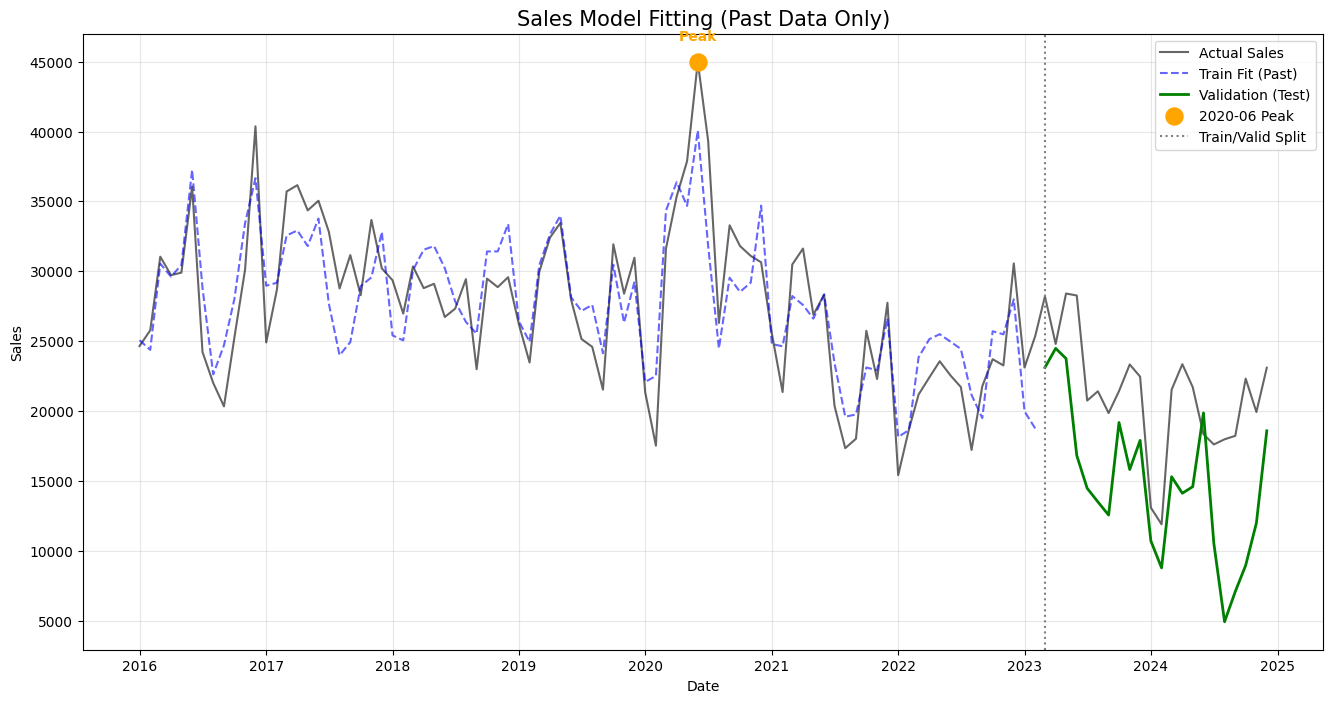

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import xgboost as xgb
from google.colab import drive

# ========================================================
# 1. 데이터 로드 및 날짜 강제 생성 (전처리)
# ========================================================
print(">>> [1단계] 데이터 로드 및 전처리...")

drive.mount('/content/drive')

try:
    file_path = '/content/drive/MyDrive/총변수최종.CSV'
    data = pd.read_csv(file_path, thousands=',')
    print(f" - 파일 로드 성공: {len(data)}행")
except Exception as e:
    print(f"!! 파일 로드 오류: {e}")
    # (테스트용 더미 데이터)
    data = pd.DataFrame({'날짜': range(108), '국내(PC차량)': [20000 + x*10 for x in range(108)]})

# [날짜 처리] 2016-01부터 강제 생성
data['ds'] = pd.date_range(start='2016-01-01', periods=len(data), freq='MS')

# 불필요한 날짜 컬럼 제거
date_cols_to_drop = ['일시', 'Date', 'date', 'Time', 'time', '년월', '시점', '날짜']
data = data.drop(columns=[c for c in date_cols_to_drop if c in data.columns], errors='ignore')

# 타겟 및 변수 분리
target_col = '국내(PC차량)'
X_all = data.drop(['ds', target_col], axis=1)
X_all = X_all.select_dtypes(include=[np.number]).ffill().bfill()
y_all = data[target_col]


# ========================================================
# 2. 중요 변수 Top 5 선정 & 정규화
# ========================================================
print("\n>>> [2단계] 변수 5개 선정 및 정규화...")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_all, y_all)
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
top_5_cols = importances.sort_values(ascending=False).head(5).index.tolist()
print(f" - 선정된 변수: {top_5_cols}")

scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[top_5_cols] = scaler.fit_transform(data[top_5_cols])


# ========================================================
# 3. 모델 학습 (과적합 방지 강화)
# ========================================================
print("\n>>> [3단계] 앙상블 모델 학습 (Strong Regularization)...")

# 데이터셋 준비
df_prophet = pd.DataFrame()
df_prophet['ds'] = data['ds']
df_prophet['y'] = y_all.values
for col in top_5_cols:
    df_prophet[col] = data_scaled[col].values

# 학습/검증 분리 (8:2)
split_idx = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_idx]
valid_df = df_prophet.iloc[split_idx:]

# (A) Prophet 학습 (추세 둔감화 강화)
model_prophet = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
    changepoint_prior_scale=0.005 # [중요] 0.01 -> 0.005로 더 낮춤 (추세 민감도 감소)
)
for col in top_5_cols:
    model_prophet.add_regressor(col)
model_prophet.fit(train_df)

# (B) XGBoost 학습 (모델 단순화 강화)
forecast_train = model_prophet.predict(train_df)
y_train_resid = train_df['y'].values - forecast_train['yhat'].values
X_train_xgb = df_prophet[top_5_cols].iloc[:split_idx]

model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=30,       # [수정] 트리 개수 50 -> 30 (학습 조기 중단)
    learning_rate=0.05,
    max_depth=1,           # [수정] 깊이 2 -> 1 (매우 단순한 트리 사용)
    subsample=0.6,         # 데이터 60%만 사용
    colsample_bytree=0.7,  # 변수 70%만 사용
    reg_alpha=0.5,         # L1 규제 강화
    random_state=42, n_jobs=-1
)
model_xgb.fit(X_train_xgb, y_train_resid)


# ========================================================
# 4. 검증 및 전체 결과 확인
# ========================================================
print("\n>>> [4단계] 모델 적합도 확인 및 시각화...")

# 전체 기간에 대한 예측값 생성
forecast_all = model_prophet.predict(df_prophet)
pred_prophet_all = forecast_all['yhat'].values
pred_resid_all = model_xgb.predict(df_prophet[top_5_cols])
final_pred_all = pred_prophet_all + pred_resid_all

# RMSE 평가 (검증 데이터 기준)
valid_pred = final_pred_all[split_idx:]
valid_true = valid_df['y'].values
rmse = np.sqrt(mean_squared_error(valid_true, valid_pred))
print(f" - 검증 데이터(최근 20%) RMSE: {rmse:,.0f}")

# 시각화
plt.figure(figsize=(16, 8))

# 1) 실제값 (검은색)
plt.plot(df_prophet['ds'], y_all, label='Actual Sales', color='black', linewidth=1.5, alpha=0.6)

# 2) 학습 구간 예측 (파란색 점선)
train_dates = df_prophet['ds'][:split_idx]
train_preds = final_pred_all[:split_idx]
plt.plot(train_dates, train_preds, label='Train Fit (Past)', color='blue', linestyle='--', alpha=0.6)

# 3) 검증 구간 예측 (초록색 실선 - 여기가 진짜 실력)
valid_dates = df_prophet['ds'][split_idx:]
valid_preds = final_pred_all[split_idx:]
plt.plot(valid_dates, valid_preds, label='Validation (Test)', color='green', linewidth=2)

# [검증] 2020년 6월 피크 지점 표시
peak_date_check = pd.to_datetime('2020-06-01')
if peak_date_check in df_prophet['ds'].values:
    real_val = df_prophet.loc[df_prophet['ds'] == peak_date_check, 'y'].values[0]
    plt.scatter(peak_date_check, real_val, color='orange', s=150, zorder=5, label='2020-06 Peak')
    plt.text(peak_date_check, real_val+1500, 'Peak', color='orange', fontweight='bold', ha='center')

# 학습/검증 구분선
plt.axvline(x=valid_dates.iloc[0], color='gray', linestyle=':', label='Train/Valid Split')

plt.title('Sales Model Fitting (Past Data Only)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()